## <center><h1>Peddagopu_Vishal_Veda_Vyas-Final_Project</h1></center>

Name: Vishal Veda Vyas Peddagopu
<br>
Github Username: vishalvedavyaspeddagopu
<br>
USC ID: 6534039283

In [1]:
import os
import cv2
import keras
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Flatten
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Model

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import subprocess

try:
    import splitfolders
except ImportError:
    subprocess.check_call(["pip3", "install", "split-folders"])
    import splitfolders

1(a), 1(b), 1(c), 1(d)(i), 1(d)(ii) - We split images into train, validation and test datasets in the below cell.<br><br> 1(d)(iii) The images are also resized to (224, 224) in the below cell.<br><br>
Answer for part 1(e)(ii) to perform empirical regularization by cropping, randomly zooming, rotating, flipping, by contrast, and translating images in the training set for image augmentation can also be found in the below cell

In [4]:
# https://www.tensorflow.org/tutorials/images/classification
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://medium.com/nerd-for-tech/easily-split-your-directory-into-train-validation-and-testing-format-f1359f34dd93

exclude_path = os.path.join('../data/Sport Images', 'Image URLs')
if os.path.exists(exclude_path):
  shutil.rmtree(exclude_path)

splitfolders.ratio("../data/Sport Images",
                   output="../data/Images",
                   seed=42,
                   ratio=(.7, .15, .15),
                   group_prefix=None,
                   move=False
                   )

# Define data augmentation parameters
datagen = ImageDataGenerator(
  rotation_range=20,
  zoom_range=0.2,
  width_shift_range=0.2,
  height_shift_range=0.2,
  horizontal_flip=True,
  vertical_flip=False,
  brightness_range=(0.8, 1.2)
)

# Data generator without augmentation
datagen_noaug = ImageDataGenerator()

# Load training images from directory and apply data augmentation
train_data = datagen.flow_from_directory(
  '../data/Images/train',
  target_size=(224, 224),
  batch_size=5,
  class_mode='categorical'
)

# Load validation images from directory without data augmentation
valid_data = datagen_noaug.flow_from_directory(
  '../data/Images/val',
  target_size=(224, 224),
  batch_size=5,
  class_mode='categorical'
)

# Load test images from directory without data augmentation
test_data = datagen_noaug.flow_from_directory(
  '../data/Images/test',
  target_size=(224, 224),
  batch_size=5,
  class_mode='categorical',
  shuffle=False
)

Copying files: 3280 files [00:01, 2015.41 files/s]

Found 2281 images belonging to 5 classes.


Found 487 images belonging to 5 classes.
Found 494 images belonging to 5 classes.


In [5]:
# Load training images from directory without shuffle (Only for train error estimation)
train_data_noshuffle = datagen_noaug.flow_from_directory(
  '../data/Images/train',
  target_size=(224, 224),
  batch_size=5,
  class_mode='categorical',
  shuffle=False
)

Found 2281 images belonging to 5 classes.


Answers for 1(e)(i), 1(e)(iii), 1(e)(iv), and 1(e)(v) can be found in the following cells for classifiers based on resnet, efficientnet and vgg models.
<br><br>
Let's now create a model based on ResNet50<br>
- Last layer is removed and remaining layers are freezed
- We add layers to model in the following order (Resnet > BatchNormalization > ReLU activation > Dropout > Softmax)

In [6]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

num_classes = 5

input_shape = (224, 224, 3)

resnet = ResNet50(weights='imagenet', include_top=True, input_shape=input_shape)

x = resnet.layers[-2].output

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

resnet_model = Model(inputs=resnet.input, outputs=output_layer)

for layer in resnet_model.layers[:-4]:
  layer.trainable=False

print(resnet_model.summary())

Metal device set to: Apple M1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

Let's now train our Resnet-based model for 100 epochs with early stopping based on validation accuracy - 

In [7]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

resnet_history = resnet_model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[early_stopping])

Epoch 1/100


2023-05-08 00:36:01.082740: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


457/457 [==============================] - 55s 117ms/step - loss: 1.0664 - accuracy: 0.6085 - val_loss: 0.4513 - val_accuracy: 0.8501
Epoch 2/100
457/457 [==============================] - 34s 75ms/step - loss: 0.7948 - accuracy: 0.7199 - val_loss: 0.3993 - val_accuracy: 0.8809
Epoch 3/100
457/457 [==============================] - 34s 75ms/step - loss: 0.6866 - accuracy: 0.7624 - val_loss: 0.3448 - val_accuracy: 0.9014
Epoch 4/100
457/457 [==============================] - 35s 76ms/step - loss: 0.6759 - accuracy: 0.7598 - val_loss: 0.3650 - val_accuracy: 0.8891
Epoch 5/100
457/457 [==============================] - 38s 84ms/step - loss: 0.6484 - accuracy: 0.7782 - val_loss: 0.3672 - val_accuracy: 0.8932
Epoch 6/100
457/457 [==============================] - 40s 87ms/step - loss: 0.6345 - accuracy: 0.7852 - val_loss: 0.3460 - val_accuracy: 0.9055
Epoch 7/100
457/457 [==============================] - 41s 91ms/step - loss: 0.6254 - accuracy: 0.7896 - val_loss: 0.3465 - val_accuracy: 0.8

In [8]:
resnet_stopped_epoch = early_stopping.stopped_epoch
print('Early stopping | Last epoch number -', resnet_stopped_epoch)

Early stopping | Last epoch number - 32


Plotting the training and validation errors vs. epochs for Resnet-based model

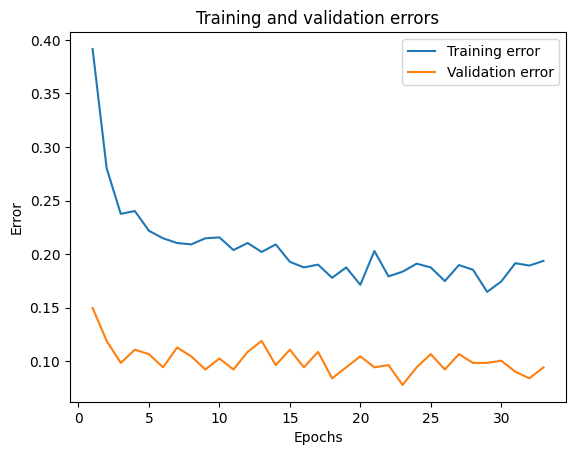

In [9]:
# extract the training and validation accuracy values
train_acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

# compute the training and validation errors
train_err = [1 - acc for acc in train_acc]
val_err = [1 - acc for acc in val_acc]

# create a list of epoch numbers
epochs = range(1, len(train_acc) + 1)

# plot the training and validation errors
plt.plot(epochs, train_err, label='Training error')
plt.plot(epochs, val_err, label='Validation error')
plt.title('Training and validation errors')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [10]:
print('\nTest Results -\n')
resnet_predictions = resnet_model.predict(test_data, batch_size=len(test_data))

y_pred = np.argmax(resnet_predictions, axis=1)

print('\nTrue classes -\n', test_data.classes)
print('\nPredicted classes -\n', y_pred)

# Compute the confusion matrix
conf_mat = confusion_matrix(test_data.classes, y_pred)

# Compute the classification report
class_report = classification_report(test_data.classes, y_pred)

# Compute the accuracy score
acc_score = accuracy_score(test_data.classes, y_pred)

# Print the results
print('\nConfusion Matrix:\n', conf_mat)
print('\nClassification Report:\n', class_report)
print('\nAccuracy Score:', acc_score)


Test Results -

99/99 [==============================] - 8s 71ms/step

True classes -
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4

In [11]:
print('\nTraining Set Results -\n')
# Train results
resnet_predictions = resnet_model.predict(train_data_noshuffle, batch_size=10)

y_pred = np.argmax(resnet_predictions, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(train_data_noshuffle.classes, y_pred)

# Compute the classification report
class_report = classification_report(train_data_noshuffle.classes, y_pred)

# Compute the accuracy score
acc_score = accuracy_score(train_data_noshuffle.classes, y_pred)

# Print the results
print('\nConfusion Matrix:\n', conf_mat)
print('\nClassification Report:\n', class_report)
print('\nAccuracy Score:', acc_score)


Training Set Results -

457/457 [==============================] - 29s 63ms/step

Confusion Matrix:
 [[503   1   3   3   1]
 [  3 325   2   6   7]
 [  6   1 423   1   4]
 [ 16   1   4 474   5]
 [  8  10  25   5 444]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       511
           1       0.96      0.95      0.95       343
           2       0.93      0.97      0.95       435
           3       0.97      0.95      0.96       500
           4       0.96      0.90      0.93       492

    accuracy                           0.95      2281
   macro avg       0.95      0.95      0.95      2281
weighted avg       0.95      0.95      0.95      2281


Accuracy Score: 0.9508987286277948


Let's now create a model based on EfficientNetB0<br>
- Last layer is removed and remaining layers are freezed
- We add layers to model in the following order (EfficientNet > BatchNormalization > ReLU activation > Dropout > Softmax)

In [12]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

num_classes = 5

input_shape = (224, 224, 3)

efficientnet = EfficientNetB0(weights='imagenet', include_top=True, input_shape=input_shape)

x = efficientnet.layers[-2].output

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

efficientnet_model = Model(inputs=efficientnet.input, outputs=output_layer)

for layer in efficientnet_model.layers[:-4]:
  layer.trainable=False

print(efficientnet_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

Let's now train our EfficientNet-based model for 100 epochs with early stopping based on validation accuracy - 

In [13]:
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

efficientnet_history = efficientnet_model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[early_stopping])

Epoch 1/100
457/457 [==============================] - 39s 76ms/step - loss: 0.7451 - accuracy: 0.7365 - val_loss: 0.2560 - val_accuracy: 0.9179
Epoch 2/100
457/457 [==============================] - 31s 67ms/step - loss: 0.4943 - accuracy: 0.8330 - val_loss: 0.2013 - val_accuracy: 0.9384
Epoch 3/100
457/457 [==============================] - 30s 66ms/step - loss: 0.4191 - accuracy: 0.8549 - val_loss: 0.1598 - val_accuracy: 0.9487
Epoch 4/100
457/457 [==============================] - 30s 65ms/step - loss: 0.3902 - accuracy: 0.8641 - val_loss: 0.1999 - val_accuracy: 0.9466
Epoch 5/100
457/457 [==============================] - 30s 66ms/step - loss: 0.4050 - accuracy: 0.8619 - val_loss: 0.1951 - val_accuracy: 0.9425
Epoch 6/100
457/457 [==============================] - 30s 66ms/step - loss: 0.3881 - accuracy: 0.8672 - val_loss: 0.1830 - val_accuracy: 0.9405
Epoch 7/100
457/457 [==============================] - 30s 66ms/step - loss: 0.3252 - accuracy: 0.8895 - val_loss: 0.2016 - val_ac

In [14]:
efficientnet_stopped_epoch = early_stopping.stopped_epoch
print('Early stopping | Last epoch number -', efficientnet_stopped_epoch)

Early stopping | Last epoch number - 19


Plotting the training and validation errors vs. epochs for EfficientNet-based model

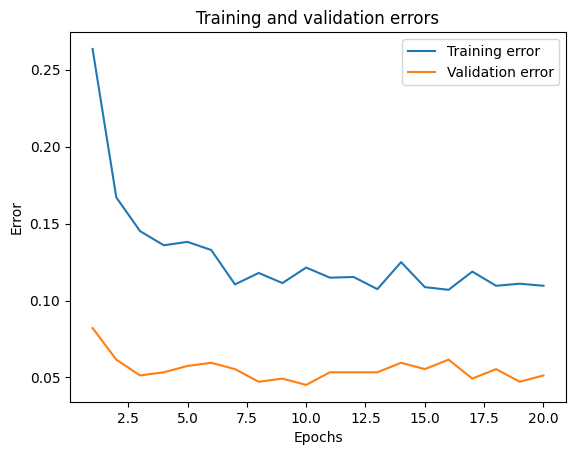

In [15]:
# extract the training and validation accuracy values
train_acc = efficientnet_history.history['accuracy']
val_acc = efficientnet_history.history['val_accuracy']

# compute the training and validation errors
train_err = [1 - acc for acc in train_acc]
val_err = [1 - acc for acc in val_acc]

# create a list of epoch numbers
epochs = range(1, len(train_acc) + 1)

# plot the training and validation errors
plt.plot(epochs, train_err, label='Training error')
plt.plot(epochs, val_err, label='Validation error')
plt.title('Training and validation errors')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [16]:
print('\nTest Results -\n')
efficientnet_predictions = efficientnet_model.predict(test_data, batch_size=len(test_data))

y_pred = np.argmax(efficientnet_predictions, axis=1)

print('\nTrue classes -\n', test_data.classes)
print('\nPredicted classes -\n', y_pred)

# Compute the confusion matrix
conf_mat = confusion_matrix(test_data.classes, y_pred)

# Compute the classification report
class_report = classification_report(test_data.classes, y_pred)

# Compute the accuracy score
acc_score = accuracy_score(test_data.classes, y_pred)

# Print the results
print('\nConfusion Matrix:\n', conf_mat)
print('\nClassification Report:\n', class_report)
print('\nAccuracy Score:', acc_score)


Test Results -

99/99 [==============================] - 7s 50ms/step

True classes -
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4

In [17]:
print('\nTraining Set Results -\n')
# Train results
efficientnet_predictions = efficientnet_model.predict(train_data_noshuffle, batch_size=10)

y_pred = np.argmax(efficientnet_predictions, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(train_data_noshuffle.classes, y_pred)

# Compute the classification report
class_report = classification_report(train_data_noshuffle.classes, y_pred)

# Compute the accuracy score
acc_score = accuracy_score(train_data_noshuffle.classes, y_pred)

# Print the results
print('\nConfusion Matrix:\n', conf_mat)
print('\nClassification Report:\n', class_report)
print('\nAccuracy Score:', acc_score)


Training Set Results -

457/457 [==============================] - 19s 42ms/step

Confusion Matrix:
 [[500   1   5   5   0]
 [  1 331   4   2   5]
 [  0   2 432   0   1]
 [ 12   0   2 484   2]
 [  2   8  11   3 468]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       511
           1       0.97      0.97      0.97       343
           2       0.95      0.99      0.97       435
           3       0.98      0.97      0.97       500
           4       0.98      0.95      0.97       492

    accuracy                           0.97      2281
   macro avg       0.97      0.97      0.97      2281
weighted avg       0.97      0.97      0.97      2281


Accuracy Score: 0.9710653222270934


Let's now create a model based on VGG16<br>
- Last layer is removed and remaining layers are freezed
- We add layers to model in the following order (VGG > BatchNormalization > ReLU activation > Dropout > Softmax)

In [18]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

num_classes = 5

input_shape = (224, 224, 3)

vgg = VGG16(weights='imagenet', include_top=True, input_shape=input_shape)

x = vgg.layers[-2].output

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

vgg_model = Model(inputs=vgg.input, outputs=output_layer)

for layer in vgg_model.layers[:-4]:
  layer.trainable=False

print(vgg_model.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Let's now train our VGG-based model for 100 epochs with early stopping based on validation accuracy - 

In [19]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

vgg_history = vgg_model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[early_stopping])

Epoch 1/100
457/457 [==============================] - 86s 187ms/step - loss: 0.9902 - accuracy: 0.6480 - val_loss: 0.7580 - val_accuracy: 0.8214
Epoch 2/100
457/457 [==============================] - 86s 187ms/step - loss: 0.7672 - accuracy: 0.7409 - val_loss: 0.8234 - val_accuracy: 0.8255
Epoch 3/100
457/457 [==============================] - 86s 188ms/step - loss: 0.7194 - accuracy: 0.7716 - val_loss: 0.7375 - val_accuracy: 0.8337
Epoch 4/100
457/457 [==============================] - 86s 188ms/step - loss: 0.6767 - accuracy: 0.7856 - val_loss: 0.7200 - val_accuracy: 0.8583
Epoch 5/100
457/457 [==============================] - 86s 187ms/step - loss: 0.6880 - accuracy: 0.7926 - val_loss: 0.8732 - val_accuracy: 0.8275
Epoch 6/100
457/457 [==============================] - 85s 185ms/step - loss: 0.6334 - accuracy: 0.8045 - val_loss: 0.7790 - val_accuracy: 0.8419
Epoch 7/100
457/457 [==============================] - 86s 189ms/step - loss: 0.6640 - accuracy: 0.8023 - val_loss: 0.8508 -

In [20]:
vgg_stopped_epoch = early_stopping.stopped_epoch
print('Early stopping | Last epoch number -', vgg_stopped_epoch)

Early stopping | Last epoch number - 20


Plotting the training and validation errors vs. epochs for VGG-based model

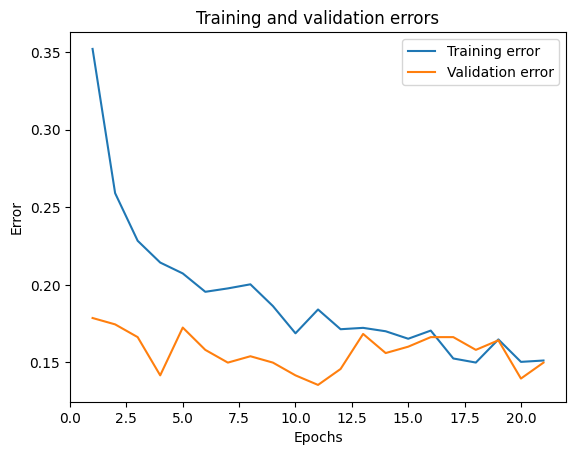

In [21]:
# extract the training and validation accuracy values
train_acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']

# compute the training and validation errors
train_err = [1 - acc for acc in train_acc]
val_err = [1 - acc for acc in val_acc]

# create a list of epoch numbers
epochs = range(1, len(train_acc) + 1)

# plot the training and validation errors
plt.plot(epochs, train_err, label='Training error')
plt.plot(epochs, val_err, label='Validation error')
plt.title('Training and validation errors')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [22]:
print('\nTest Results -\n')
vgg_predictions = vgg_model.predict(test_data, batch_size=len(test_data))

y_pred = np.argmax(vgg_predictions, axis=1)

print('\nTrue classes -\n', test_data.classes)
print('\nPredicted classes -\n', y_pred)

# Compute the confusion matrix
conf_mat = confusion_matrix(test_data.classes, y_pred)

# Compute the classification report
class_report = classification_report(test_data.classes, y_pred)

# Compute the accuracy score
acc_score = accuracy_score(test_data.classes, y_pred)

# Print the results
print('\nConfusion Matrix:\n', conf_mat)
print('\nClassification Report:\n', class_report)
print('\nAccuracy Score:', acc_score)


Test Results -

99/99 [==============================] - 14s 142ms/step

True classes -
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4

In [23]:
print('\nTraining Set Results -\n')
# Train results
vgg_predictions = vgg_model.predict(train_data_noshuffle, batch_size=10)

y_pred = np.argmax(vgg_predictions, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(train_data_noshuffle.classes, y_pred)

# Compute the classification report
class_report = classification_report(train_data_noshuffle.classes, y_pred)

# Compute the accuracy score
acc_score = accuracy_score(train_data_noshuffle.classes, y_pred)

# Print the results
print('\nConfusion Matrix:\n', conf_mat)
print('\nClassification Report:\n', class_report)
print('\nAccuracy Score:', acc_score)


Training Set Results -

457/457 [==============================] - 62s 136ms/step

Confusion Matrix:
 [[491   4   8   2   6]
 [  4 319   5   3  12]
 [  6   1 417   5   6]
 [ 38  10  13 420  19]
 [  6  14  24   1 447]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       511
           1       0.92      0.93      0.92       343
           2       0.89      0.96      0.92       435
           3       0.97      0.84      0.90       500
           4       0.91      0.91      0.91       492

    accuracy                           0.92      2281
   macro avg       0.92      0.92      0.92      2281
weighted avg       0.92      0.92      0.92      2281


Accuracy Score: 0.9180184129767646


### (f) Video Classification Using Moving Averages
1(f)(i). In order to have a better deep learner, reuse the validation and test data and
train the network, without seriously overfitting it. In the lectures, we saw
how this can be done.

From the lecture on Neural Networks and Deep Learning (and as mentioned in the slides), we can reuse validation data (and test data) in two ways without seriously overfitting the model -<br><br>
(1) Start fresh, train with whole training data, validation and test data up to the previous
number of epochs obtained through early stopping (Stop at the same epoch where the model stopped previously due to early stopping. Here, we are essentially treating the number of iterations or epochs as a hyperparameter)<br><br>
(2) Start from the weights in the first run,
train with both training data and validation
data until the training loss < the validation
loss at the early stopping point<br><br>

Here, I am following the first approach to train a model with train, validation and test data together.

In [24]:
# Load all images from directory and apply data augmentation
full_train_data = datagen.flow_from_directory(
  '../data/Sport Images',
  target_size=(224, 224),
  batch_size=5,
  class_mode='categorical'
)

Found 3262 images belonging to 5 classes.


Answers for 1(f)(ii), 1(f)(iii), and 1(f)(iv) can be found in the following cells for classifiers based on resnet, efficientnet and vgg models.


In [25]:
sports_videos_path = '../data/Sport Videos'

num_frames = 100

def getFrames(video_file):
    video_frames = []
    # open the video file
    cap = cv2.VideoCapture(video_file)

    # get the total number of frames in the video
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_interval = max(1, num_frames // 100)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        # break the loop if the video has ended
        if not ret:
            break
        if frame_count % frame_interval == 0:
            video_frames.append(frame)
            
        frame_count += 1
        if frame_count >= num_frames or frame_count >= 100:
            break
    cap.release()
    return video_frames

class_label_map = {'BaseballPitch': 0, 'Basketball': 1, 'Fencing': 2, 'TennisSwing': 3, 'VolleyballSpiking': 4}

Let's now re-train our Resnet-based model for resnet_stopped_epoch number of epochs as obtained earlier through early stopping.

In [26]:
num_classes = 5

input_shape = (224, 224, 3)

new_resnet = ResNet50(weights='imagenet', include_top=True, input_shape=input_shape)

x = new_resnet.layers[-2].output

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

new_resnet_model = Model(inputs=new_resnet.input, outputs=output_layer)

for layer in new_resnet_model.layers[:-4]:
  layer.trainable=False

new_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

new_resnet_history = new_resnet_model.fit(full_train_data, epochs=resnet_stopped_epoch)

Epoch 1/32
653/653 [==============================] - 66s 97ms/step - loss: 1.0037 - accuracy: 0.6309
Epoch 2/32
653/653 [==============================] - 61s 93ms/step - loss: 0.7559 - accuracy: 0.7342
Epoch 3/32
653/653 [==============================] - 61s 93ms/step - loss: 0.7015 - accuracy: 0.7621
Epoch 4/32
653/653 [==============================] - 61s 94ms/step - loss: 0.7048 - accuracy: 0.7615
Epoch 5/32
653/653 [==============================] - 61s 94ms/step - loss: 0.6619 - accuracy: 0.7820
Epoch 6/32
653/653 [==============================] - 61s 94ms/step - loss: 0.6625 - accuracy: 0.7756
Epoch 7/32
653/653 [==============================] - 62s 94ms/step - loss: 0.6260 - accuracy: 0.7977
Epoch 8/32
653/653 [==============================] - 61s 94ms/step - loss: 0.6219 - accuracy: 0.7918
Epoch 9/32
653/653 [==============================] - 61s 94ms/step - loss: 0.6197 - accuracy: 0.8056
Epoch 10/32
653/653 [==============================] - 62s 95ms/step - loss: 0.644

Predictions and metrics of test data(videos) for Resnet-based model.

In [27]:
new_resnet_model_predictions = []
actual_classes = []

for sport_folder in os.listdir(sports_videos_path):
    sport_folder_path = os.path.join(sports_videos_path, sport_folder)
    if '.DS_Store' in sport_folder_path:
        continue
    for video_file in os.listdir(sport_folder_path):
        video_file_path = os.path.join(sport_folder_path, video_file)
        filename, extension = os.path.splitext(video_file_path)
        if extension == ".avi":
            frames = getFrames(video_file_path)
            processed_frames = []
            for frame in frames:
                img_arr = cv2.resize(frame, (224, 224))
                processed_frames.append(img_arr)
            new_resnet_predictions = new_resnet_model.predict(np.array(processed_frames))
            new_resnet_model_predictions.append(np.argmax(np.mean(new_resnet_predictions, axis=0)))
            actual_classes.append(class_label_map[sport_folder])


2/2 [==============================] - 0s 384ms/step


4/4 [==============================] - 1s 381ms/step


3/3 [==============================] - 1s 489ms/step


4/4 [==============================] - 1s 388ms/step


4/4 [==============================] - 1s 392ms/step


In [28]:
# Compute the confusion matrix
conf_mat = confusion_matrix(actual_classes, new_resnet_model_predictions)

# Compute the classification report
class_report = classification_report(actual_classes, new_resnet_model_predictions)

# Compute the accuracy score
acc_score = accuracy_score(actual_classes, new_resnet_model_predictions)

# Print the results
print('\nConfusion Matrix:\n', conf_mat)
print('\nClassification Report:\n', class_report)
print('\nAccuracy Score:', acc_score)


Confusion Matrix:
 [[ 52   6  11  79   2]
 [  0   6  76  46   9]
 [  1   0 107   1   2]
 [ 16   0   9 137   5]
 [  0   1  80  15  20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.35      0.47       150
           1       0.46      0.04      0.08       137
           2       0.38      0.96      0.54       111
           3       0.49      0.82      0.62       167
           4       0.53      0.17      0.26       116

    accuracy                           0.47       681
   macro avg       0.52      0.47      0.39       681
weighted avg       0.53      0.47      0.40       681


Accuracy Score: 0.47283406754772395


Let's now re-train our Efficient-based model for efficientnet_stopped_epoch number of epochs as obtained earlier through early stopping.

In [29]:
num_classes = 5

input_shape = (224, 224, 3)

new_efficientnet = EfficientNetB0(weights='imagenet', include_top=True, input_shape=input_shape)

x = new_efficientnet.layers[-2].output

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

new_efficientnet_model = Model(inputs=new_efficientnet.input, outputs=output_layer)

for layer in new_efficientnet_model.layers[:-4]:
  layer.trainable=False

new_efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

new_efficientnet_history = new_efficientnet_model.fit(full_train_data, epochs=efficientnet_stopped_epoch)

Epoch 1/19
653/653 [==============================] - 50s 70ms/step - loss: 0.7315 - accuracy: 0.7406
Epoch 2/19
653/653 [==============================] - 41s 63ms/step - loss: 0.4698 - accuracy: 0.8406
Epoch 3/19
653/653 [==============================] - 42s 64ms/step - loss: 0.4374 - accuracy: 0.8547
Epoch 4/19
653/653 [==============================] - 41s 63ms/step - loss: 0.4386 - accuracy: 0.8642
Epoch 5/19
653/653 [==============================] - 41s 62ms/step - loss: 0.3806 - accuracy: 0.8673
Epoch 6/19
653/653 [==============================] - 41s 62ms/step - loss: 0.3867 - accuracy: 0.8706
Epoch 7/19
653/653 [==============================] - 41s 63ms/step - loss: 0.3677 - accuracy: 0.8838
Epoch 8/19
653/653 [==============================] - 41s 63ms/step - loss: 0.3922 - accuracy: 0.8712
Epoch 9/19
653/653 [==============================] - 41s 63ms/step - loss: 0.3581 - accuracy: 0.8850
Epoch 10/19
653/653 [==============================] - 42s 64ms/step - loss: 0.352

Predictions and metrics of test data(videos) for Efficientnet-based model.

In [30]:
new_efficientnet_model_predictions = []
actual_classes = []

for sport_folder in os.listdir(sports_videos_path):
    sport_folder_path = os.path.join(sports_videos_path, sport_folder)
    if '.DS_Store' in sport_folder_path:
        continue
    for video_file in os.listdir(sport_folder_path):
        video_file_path = os.path.join(sport_folder_path, video_file)
        filename, extension = os.path.splitext(video_file_path)
        if extension == ".avi":
            frames = getFrames(video_file_path)
            processed_frames = []
            for frame in frames:
                img_arr = cv2.resize(frame, (224, 224))
                processed_frames.append(img_arr)
            new_efficientnet_predictions = new_efficientnet_model.predict(np.array(processed_frames))
            new_efficientnet_model_predictions.append(np.argmax(np.mean(new_efficientnet_predictions, axis=0)))
            actual_classes.append(class_label_map[sport_folder])

4/4 [==============================] - 1s 240ms/step


4/4 [==============================] - 1s 219ms/step


3/3 [==============================] - 1s 265ms/step


4/4 [==============================] - 1s 285ms/step


4/4 [==============================] - 1s 248ms/step


In [31]:
# Compute the confusion matrix
conf_mat = confusion_matrix(actual_classes, new_efficientnet_model_predictions)

# Compute the classification report
class_report = classification_report(actual_classes, new_efficientnet_model_predictions)

# Compute the accuracy score
acc_score = accuracy_score(actual_classes, new_efficientnet_model_predictions)

# Print the results
print('\nConfusion Matrix:\n', conf_mat)
print('\nClassification Report:\n', class_report)
print('\nAccuracy Score:', acc_score)


Confusion Matrix:
 [[101   1  25  23   0]
 [  0   0 111  18   8]
 [  0   0 111   0   0]
 [ 44   0  33  89   1]
 [  0   0  80   0  36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.67      0.68       150
           1       0.00      0.00      0.00       137
           2       0.31      1.00      0.47       111
           3       0.68      0.53      0.60       167
           4       0.80      0.31      0.45       116

    accuracy                           0.49       681
   macro avg       0.50      0.50      0.44       681
weighted avg       0.51      0.49      0.45       681


Accuracy Score: 0.4948604992657856


Let's now re-train our VGG-based model for vgg_stopped_epoch number of epochs as obtained earlier through early stopping.

In [32]:
num_classes = 5

input_shape = (224, 224, 3)

new_vgg = VGG16(weights='imagenet', include_top=True, input_shape=input_shape)

x = new_vgg.layers[-2].output

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

new_vgg_model = Model(inputs=new_vgg.input, outputs=output_layer)

for layer in new_vgg_model.layers[:-4]:
  layer.trainable=False

new_vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

new_vgg_history = new_vgg_model.fit(full_train_data, epochs=vgg_stopped_epoch)


Epoch 1/20
653/653 [==============================] - 107s 161ms/step - loss: 0.9745 - accuracy: 0.6842
Epoch 2/20
653/653 [==============================] - 105s 161ms/step - loss: 0.7799 - accuracy: 0.7557
Epoch 3/20
653/653 [==============================] - 104s 160ms/step - loss: 0.7592 - accuracy: 0.7777
Epoch 4/20
653/653 [==============================] - 104s 160ms/step - loss: 0.6947 - accuracy: 0.7897
Epoch 5/20
653/653 [==============================] - 104s 160ms/step - loss: 0.6740 - accuracy: 0.8001
Epoch 6/20
653/653 [==============================] - 105s 161ms/step - loss: 0.6973 - accuracy: 0.7992
Epoch 7/20
653/653 [==============================] - 104s 159ms/step - loss: 0.6771 - accuracy: 0.8155
Epoch 8/20
653/653 [==============================] - 104s 160ms/step - loss: 0.6801 - accuracy: 0.8112
Epoch 9/20
653/653 [==============================] - 104s 159ms/step - loss: 0.6429 - accuracy: 0.8213
Epoch 10/20
653/653 [==============================] - 104s 159m

Predictions and metrics of test data(videos) for VGG-based model.

In [33]:
new_vgg_model_predictions = []
actual_classes = []

for sport_folder in os.listdir(sports_videos_path):
    sport_folder_path = os.path.join(sports_videos_path, sport_folder)
    if '.DS_Store' in sport_folder_path:
        continue
    for video_file in os.listdir(sport_folder_path):
        video_file_path = os.path.join(sport_folder_path, video_file)
        filename, extension = os.path.splitext(video_file_path)
        if extension == ".avi":
            frames = getFrames(video_file_path)
            processed_frames = []
            for frame in frames:
                img_arr = cv2.resize(frame, (224, 224))
                processed_frames.append(img_arr)
            new_vgg_predictions = new_vgg_model.predict(np.array(processed_frames))
            new_vgg_model_predictions.append(np.argmax(np.mean(new_vgg_predictions, axis=0)))
            actual_classes.append(class_label_map[sport_folder])


2/2 [==============================] - 1s 683ms/step


4/4 [==============================] - 2s 725ms/step


4/4 [==============================] - 2s 720ms/step


4/4 [==============================] - 2s 717ms/step


4/4 [==============================] - 2s 725ms/step


In [34]:
# Compute the confusion matrix
conf_mat = confusion_matrix(actual_classes, new_vgg_model_predictions)

# Compute the classification report
class_report = classification_report(actual_classes, new_vgg_model_predictions)

# Compute the accuracy score
acc_score = accuracy_score(actual_classes, new_vgg_model_predictions)

# Print the results
print('\nConfusion Matrix:\n', conf_mat)
print('\nClassification Report:\n', class_report)
print('\nAccuracy Score:', acc_score)


Confusion Matrix:
 [[125   0  13  11   1]
 [ 24   0  48  23  42]
 [  2   0 107   1   1]
 [ 37   0  14 105  11]
 [  3   0  77   8  28]]

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.83      0.73       150
           1       0.00      0.00      0.00       137
           2       0.41      0.96      0.58       111
           3       0.71      0.63      0.67       167
           4       0.34      0.24      0.28       116

    accuracy                           0.54       681
   macro avg       0.42      0.53      0.45       681
weighted avg       0.44      0.54      0.47       681


Accuracy Score: 0.5359765051395007
